In [25]:
#Mitchell Schiworski, Jan 2019
#
#Code to insert a new OZHF detector into a network with H1,L1,V1 operating at A+ and
#move the OZHF detector to different locations in Australia.
#Afterwards, a NSNS signal is injected and the network is tested by
#attempting to recover sky localisation data.

import numpy as np
import bilby
import gwinc
import matplotlib.pyplot as plt
import functools
import sys
import io
import cartopy.crs as ccrs
import scipy
import time

suppress_sampler = False #if true, will suppress all output from the sampler
hide_plots = True #if true, will suppress output of all plots other than the 95% cred area plots

In [2]:
def get_95CI_area(sample_array) :
    #gets the 95% credible area from the sample array passed
    Dec = scipy.stats.bayes_mvs(sample_array[:,0],0.95)
    RA = scipy.stats.bayes_mvs(sample_array[:,1],0.95)

    Dec_bounds = Dec[0][1]
    RA_bounds = RA[0][1]

    #-?-calculate sky area from these limits
    area = np.pi*( abs(Dec_bounds[1]-Dec_bounds[0]) * abs(RA_bounds[1]-RA_bounds[0]) )
    return area

def plot_cities() :
    #---plots capital cities of Aus---
                 #  Adel ,  Perth,   Darw,  Bris ,   Syd , Can   , Melb  #
    city_lats =  [-34.92 , -31.95, -12.46, -27.47, -33.87, -35.28, -37.81]
    city_longs = [ 138.59, 115.85, 130.84, 153.02, 151.21, 149.13, 144.96]
    
    for ii in range(len(city_lats)) :
        plt.plot(city_longs[ii],city_lats[ii],marker='.',color='black',linestyle="")
        
def normalise_vector(vector) :
    #normalises the vector passed to the function, so that all values lie between 0 and 1
    if max(vector) == min(vector) :
        norm_vector = [1 for  i in vector]
    else :
        norm_vector = [( i - min(vector))/( max(vector) - min(vector) ) for i in vector]
    return norm_vector

def convert_to_coord_matrix(vector) :
    #converts a vector back into a square meshgrid of co-ords.
    n = int(np.sqrt(float(len(vector))))
    Z = [[0] * n for i in range(n)]
    index_count=0
    for ii in range(n):
        for jj in range(n):
            Z[ii][jj] = vector[index_count]
            index_count=index_count+1
    return(Z)

def run_sampler_with_detector_coords(i) :
    #runs the sampler, with a OZHF detector at the given lat/long
    #i is the index of the co-ords chosen from the proposed_latitude & proposed_longitude vectors.


    ifos = existing_ifos
    ifos.append(OZHF_list[i])

    priors = bilby.gw.prior.BNSPriorDict()
    for variable in [    'mass_1', 'mass_2', 'chi_1', 'chi_2', 'luminosity_distance',
        'iota', 'psi', 'phase', 'geocent_time', 'lambda_1', 'lambda_2']:
        priors[variable] = injection_parameters[variable]


    #----- inject signal into detectors -----
    for interferometer in ifos:
        interferometer.set_strain_data_from_power_spectral_density(
            sampling_frequency=sampling_frequency, duration=duration,
            start_time=start_time)
        interferometer.inject_signal(parameters=injection_parameters,
                                  waveform_generator=waveform_generator)

    #----- create likelihood -----

    likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator\
    ,time_marginalization=True,phase_marginalization=True,distance_marginalization=False\
    ,priors=priors)



    #----- Run Sampler -----


    sampler = 'nestle'
    npoints = 10
    result = bilby.core.sampler.run_sampler(likelihood=likelihood, priors=priors, outdir='OZHF_locations_with_H1_L1_V1_outdir',sampler=sampler,npoints=npoints\
                              ,injection_parameters=injection_parameters)



    #----- write useful Data to file ----

    fp.write('%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\n' \
             %(proposed_latitude[i],proposed_longitude[i],result.get_injection_credible_level('ra')\
               ,result.get_injection_credible_level('dec'),result.log_bayes_factor,result.log_evidence\
               ,result.posterior_volume,get_95CI_area(result.samples)))

In [3]:
#-------- Create NSNS signal --------
#(code taken from bibly injection example)

injection_parameters = dict(
    mass_1=1.5, mass_2=1.3, chi_1=0.02, chi_2=0.02, luminosity_distance=50.,
    iota=0.4, psi=2.659, phase=1.3, geocent_time=1126259642.413,
    ra=1.375, dec=-1.2108, lambda_1=400, lambda_2=450)


# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 8
sampling_frequency = 2 * 1570.
start_time = injection_parameters['geocent_time'] + 2 - duration

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(waveform_approximant='TaylorF2',
                          reference_frequency=50., minimum_frequency=40.0)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments)

In [4]:
#-------- Create prior for BNS ----

# Use delta functions about injected value for all but RA / Dec
priors = bilby.gw.prior.BNSPriorDict()
for variable in [    'mass_1', 'mass_2', 'chi_1', 'chi_2', 'luminosity_distance',
    'iota', 'psi', 'phase', 'geocent_time', 'lambda_1', 'lambda_2']:
    priors[variable] = injection_parameters[variable]



11:21 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]


In [5]:
#-------- Create OZHF detector profile --------
detector_min_freq = 8
detector_max_freq = 1000
detector_Xarm_aximuth = 2.0 #-?-same as in bibly documentation example
detector_Yarm_aximuth = 125.0

OZHF_freqs = np.logspace(np.log10(detector_min_freq),np.log10(detector_max_freq),1000)
OZHF_gwinc = gwinc.load_ifo('./ozhf.yaml')

OZHF_gwinc.Infrastructure.Length = 4000
OZHF_gwinc.Optics.Curvature.ETM = OZHF_gwinc.Infrastructure.Length*0.6
OZHF_gwinc.Optics.Curvature.ITM = OZHF_gwinc.Infrastructure.Length*0.6


OZHF_gwinc = gwinc.precompIFO(OZHF_freqs, OZHF_gwinc)
OZHF_gwinc_noises = gwinc.noise_calc(OZHF_freqs, OZHF_gwinc)
OZHF_psd = OZHF_gwinc_noises['Total']

    #--plot noise profile--
    #fig = gwinc.plot_noise(OZHF_gwinc, OZHF_gwinc_noises)
    #fig.axes[0].set_ylim(5e-26, 1e-22)
    #fig.set_figwidth(10)
    #fig.set_figheight(6.25)

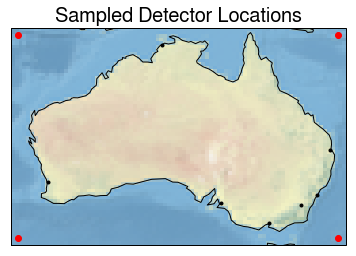

In [26]:
#-------- Create list of lat/longs & plot over map--------

#create meshgrid of lat/long inside a rectangle conatining australia
latitude_limits =  [-40.0,-11.0] #min/max values of lat/long
longitude_limits = [112.0,154.0]
number_of_latitude_points = 2
number_of_longitude_points = 2

#create a meshgrid of points within rectangle defined by the limits
mesh_lat, mesh_long = np.meshgrid(np.linspace(latitude_limits[0],latitude_limits[1],number_of_latitude_points),\
                                    np.linspace(longitude_limits[0],longitude_limits[1],number_of_longitude_points))

#flatten 2d co-ord matrices to 1-d vectors containing all combinations of points
proposed_latitude = [y for x in mesh_lat for y in x]
proposed_longitude = [y for x in mesh_long for y in x]


#---- Plot the sampled locations over map of Aus ----
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
plt.plot(proposed_longitude,proposed_latitude,color='red',marker='o',linestyle="")
plt.title("Sampled Detector Locations")
plt.show()



In [7]:
#-------- Create array of proposed detectors --------
newDetector=[]
for i in range(len(proposed_latitude)) :

    OZHF = bilby.gw.detector.Interferometer(power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=OZHF_freqs,psd_array=OZHF_psd)\
                                           ,name='OZHF',length=OZHF_gwinc.Infrastructure.Length, minimum_frequency=detector_min_freq,maximum_frequency=detector_max_freq\
                                           ,latitude=proposed_latitude[i],longitude=proposed_longitude[i],elevation=0\
                                            ,xarm_azimuth=detector_Xarm_aximuth,yarm_azimuth=detector_Yarm_aximuth)
    
    newDetector.append(OZHF)
OZHF_list = bilby.gw.detector.InterferometerList(newDetector)
OZHF_list.set_strain_data_from_power_spectral_densities(
sampling_frequency=sampling_frequency, duration=duration,
start_time=start_time)

/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [8]:
#------ Create and Setup Output file -----
try:
    fp = open('./OZHF_locations_with_H1_L1_V1_outdir/credible_levels.txt',mode='w')
except IOError:
    print('Error opening file, exiting ...')
    sys.exit
    

fp.write('%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\n' \
         %("Latitude","Longitude","RA_Credible","Dec_Credible","Log_Bayes_Factor",\
           "Log_Evidence","Posterior_Volume","95_Cred_Area"))


200

In [9]:
    frequencies = np.logspace(0, 3, 1000)
    gwinc_detector = gwinc.load_ifo('A+')
    gwinc_detector = gwinc.precompIFO(frequencies, gwinc_detector)
    gwinc_noises = gwinc.noise_calc(frequencies, gwinc_detector)

    Aplus_psd = gwinc_noises['Total']

    existing_ifos = bilby.gw.detector.InterferometerList(['H1','L1','V1'])
    for interferometer in existing_ifos:
        interferometer.power_spectral_density =\
            bilby.gw.detector.PowerSpectralDensity(frequency_array=frequencies, psd_array=Aplus_psd)    
        
    existing_ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=start_time)


    OZHF_list.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=start_time)

/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [10]:
#------- Use new network with sampler ------
for i in range(len(OZHF_list)) :
    for j in range(5):
        print("--%d--\n" %(i))

    
    #start timer
    start_timer = time.time()
    
    ifos = existing_ifos
    ifos.append(OZHF_list[i])


    priors = bilby.gw.prior.BNSPriorDict()
    for variable in [    'mass_1', 'mass_2', 'chi_1', 'chi_2', 'luminosity_distance',
        'iota', 'psi', 'phase', 'geocent_time', 'lambda_1', 'lambda_2']:
        priors[variable] = injection_parameters[variable]
    
    
    #----- inject signal into detectors -----
    for interferometer in ifos:
        interferometer.set_strain_data_from_power_spectral_density(
            sampling_frequency=sampling_frequency, duration=duration,
            start_time=start_time)
        interferometer.inject_signal(parameters=injection_parameters,
                                  waveform_generator=waveform_generator)
    
    #----- create likelihood -----

    likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator\
    ,time_marginalization=True,phase_marginalization=True,distance_marginalization=False\
    ,priors=priors)

    
    end_timer = time.time()
    print("Setting up the sampler took %d seconds" %(end_timer - start_timer))
    
    #----- Run Sampler -----
    
    
    start_timer = time.time()
    
    sampler = 'nestle'
    npoints = 10
    result = bilby.core.sampler.run_sampler(likelihood=likelihood, priors=priors, outdir='OZHF_locations_with_H1_L1_V1_outdir',sampler=sampler,npoints=npoints\
                              ,injection_parameters=injection_parameters)
    

    
    end_timer = time.time()
    print("Running the sampler took %d seconds" %(end_timer - start_timer))
    #----- write useful Data to file ----

    fp.write('%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\n' \
             %(proposed_latitude[i],proposed_longitude[i],result.get_injection_credible_level('ra')\
               ,result.get_injection_credible_level('dec'),result.log_bayes_factor,result.log_evidence\
               ,result.posterior_volume,get_95CI_area(result.samples)))
    
    

11:21 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]


--0--

--0--

--0--

--0--

--0--



/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
11:21 bilby INFO    : Injected signal in H1:
11:21 bilby INFO    :   optimal SNR = 63.83
11:21 bilby INFO    :   matched filter SNR = 64.09+0.27j
11:21 bilby INFO    :   mass_1 = 1.5
11:21 bilby INFO    :   mass_2 = 1.3
11:21 bilby INFO    :   chi_1 = 0.02
11:21 bilby INFO    :   chi_2 = 0.02
11:21 bilby INFO    :   luminosity_distance = 50.0
11:21 bilby INFO    :   iota = 0.4
11:21 bilby INFO    :   psi = 2.659
11:21 bilby INFO    :   phase = 1.3
11:21 bilby INFO    :   geocent_time = 1126259642.413
11:21 bilby INFO    :   ra = 1.375
11:21 bilby INFO    :   dec = -1.2108
11:21 bilby INFO    :   lambda_1 = 400
11:21 bilby INFO    :   lambda_2 = 450
11:21 bilby INFO    : Injected signal in L1:
11:21 bilby INFO    :   optimal SNR = 51.70
11:21 bilby INFO    :   matched filter SNR = 51

Setting up the sampler took 2 seconds


11:21 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:21 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:21 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:21 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:21 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:21 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:21 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:21 bilby INFO    : No prior given, using default BBH priors

it=   137 logz=2483.54416135

11:22 bilby INFO    : Sampling time: 0:00:57.625735
11:22 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
11:22 bilby INFO    : Summary of results:
nsamples: 148
log_noise_evidence: -38479.958
log_evidence: -35995.997 +/-  1.089
log_bayes_factor: 2483.961 +/-  1.089

11:22 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.



Running the sampler took 58 seconds
--1--

--1--

--1--

--1--

--1--



11:22 bilby INFO    : Injected signal in H1:
11:22 bilby INFO    :   optimal SNR = 63.83
11:22 bilby INFO    :   matched filter SNR = 64.41-0.27j
11:22 bilby INFO    :   mass_1 = 1.5
11:22 bilby INFO    :   mass_2 = 1.3
11:22 bilby INFO    :   chi_1 = 0.02
11:22 bilby INFO    :   chi_2 = 0.02
11:22 bilby INFO    :   luminosity_distance = 50.0
11:22 bilby INFO    :   iota = 0.4
11:22 bilby INFO    :   psi = 2.659
11:22 bilby INFO    :   phase = 1.3
11:22 bilby INFO    :   geocent_time = 1126259642.413
11:22 bilby INFO    :   ra = 1.375
11:22 bilby INFO    :   dec = -1.2108
11:22 bilby INFO    :   lambda_1 = 400
11:22 bilby INFO    :   lambda_2 = 450
11:22 bilby INFO    : Injected signal in L1:
11:22 bilby INFO    :   optimal SNR = 51.70
11:22 bilby INFO    :   matched filter SNR = 51.77+0.50j
11:22 bilby INFO    :   mass_1 = 1.5
11:22 bilby INFO    :   mass_2 = 1.3
11:22 bilby INFO    :   chi_1 = 0.02
11:22 bilby INFO    :   chi_2 = 0.02
11:22 bilby INFO    :   luminosity_distance = 50.

Setting up the sampler took 2 seconds


11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors

it=   212 logz=2771.55890217

11:22 bilby INFO    : Sampling time: 0:00:15.040596


11:22 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
11:22 bilby INFO    : Summary of results:
nsamples: 223
log_noise_evidence: -47600.529
log_evidence: -44828.638 +/-  1.374
log_bayes_factor: 2771.891 +/-  1.374

11:22 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.


Running the sampler took 15 seconds
--2--

--2--

--2--

--2--

--2--



11:22 bilby INFO    : Injected signal in H1:
11:22 bilby INFO    :   optimal SNR = 63.83
11:22 bilby INFO    :   matched filter SNR = 63.30-0.81j
11:22 bilby INFO    :   mass_1 = 1.5
11:22 bilby INFO    :   mass_2 = 1.3
11:22 bilby INFO    :   chi_1 = 0.02
11:22 bilby INFO    :   chi_2 = 0.02
11:22 bilby INFO    :   luminosity_distance = 50.0
11:22 bilby INFO    :   iota = 0.4
11:22 bilby INFO    :   psi = 2.659
11:22 bilby INFO    :   phase = 1.3
11:22 bilby INFO    :   geocent_time = 1126259642.413
11:22 bilby INFO    :   ra = 1.375
11:22 bilby INFO    :   dec = -1.2108
11:22 bilby INFO    :   lambda_1 = 400
11:22 bilby INFO    :   lambda_2 = 450
11:22 bilby INFO    : Injected signal in L1:
11:22 bilby INFO    :   optimal SNR = 51.70
11:22 bilby INFO    :   matched filter SNR = 50.80+0.32j
11:22 bilby INFO    :   mass_1 = 1.5
11:22 bilby INFO    :   mass_2 = 1.3
11:22 bilby INFO    :   chi_1 = 0.02
11:22 bilby INFO    :   chi_2 = 0.02
11:22 bilby INFO    :   luminosity_distance = 50.

Setting up the sampler took 2 seconds


11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:22 bilby INFO    : No prior given, using default BBH priors

it=   171 logz=10049.8215667

11:23 bilby INFO    : Sampling time: 0:00:14.917049


11:23 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
11:23 bilby INFO    : Summary of results:
nsamples: 182
log_noise_evidence: -57527.802
log_evidence: -47477.536 +/-  1.246
log_bayes_factor: 10050.266 +/-  1.246

11:23 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.


Running the sampler took 15 seconds
--3--

--3--

--3--

--3--

--3--



11:23 bilby INFO    : Injected signal in H1:
11:23 bilby INFO    :   optimal SNR = 63.83
11:23 bilby INFO    :   matched filter SNR = 62.98+0.03j
11:23 bilby INFO    :   mass_1 = 1.5
11:23 bilby INFO    :   mass_2 = 1.3
11:23 bilby INFO    :   chi_1 = 0.02
11:23 bilby INFO    :   chi_2 = 0.02
11:23 bilby INFO    :   luminosity_distance = 50.0
11:23 bilby INFO    :   iota = 0.4
11:23 bilby INFO    :   psi = 2.659
11:23 bilby INFO    :   phase = 1.3
11:23 bilby INFO    :   geocent_time = 1126259642.413
11:23 bilby INFO    :   ra = 1.375
11:23 bilby INFO    :   dec = -1.2108
11:23 bilby INFO    :   lambda_1 = 400
11:23 bilby INFO    :   lambda_2 = 450
11:23 bilby INFO    : Injected signal in L1:
11:23 bilby INFO    :   optimal SNR = 51.70
11:23 bilby INFO    :   matched filter SNR = 52.09-0.72j
11:23 bilby INFO    :   mass_1 = 1.5
11:23 bilby INFO    :   mass_2 = 1.3
11:23 bilby INFO    :   chi_1 = 0.02
11:23 bilby INFO    :   chi_2 = 0.02
11:23 bilby INFO    :   luminosity_distance = 50.

Setting up the sampler took 2 seconds


11:23 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:23 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:23 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:23 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:23 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:23 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:23 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
11:23 bilby INFO    : No prior given, using default BBH priors

it=   145 logz=11242.9964736

11:23 bilby INFO    : Sampling time: 0:00:49.627212
11:23 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
11:23 bilby INFO    : Summary of results:
nsamples: 156
log_noise_evidence: -66727.736
log_evidence: -55484.292 +/-  1.135
log_bayes_factor: 11243.443 +/-  1.135




Running the sampler took 50 seconds


In [11]:
fp.close()

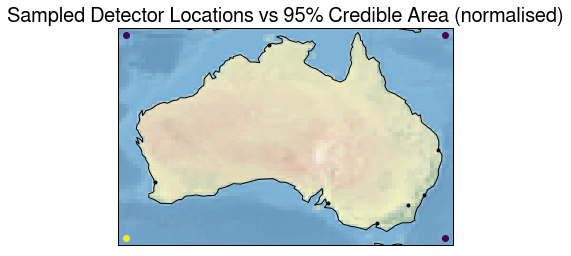

In [28]:
#---- Create plots from data file ---


#------ Create and Setup Output file -----
try:
    fp = open('./OZHF_locations_with_H1_L1_V1_outdir/credible_levels.txt',mode='r')
except IOError:
    print('Error opening file, exiting ...')
    sys.exit

#------ read from file -------
lats = []
longs = []
bayes_factors = []
RA_cred = []
Dec_cred = []
Posterior_Volume = []
bayes_evidence=[]
cred_area=[]
for i,line in enumerate(fp) :
    line = " ".join(line.split())
    line = line.split(" ")
    if i == 0:
        continue
    lats.append(line[0])
    longs.append(line[1])
    RA_cred.append(line[2])
    Dec_cred.append(line[3])
    bayes_factors.append(line[4])
    bayes_evidence.append(line[5])
    Posterior_Volume.append(line[6])
    cred_area.append(line[7])

mean_cred = [(float(i)+float(j))/2 for i in RA_cred for j in Dec_cred]
#-------- Conver to floats and normalise --------

bayes_factors=[float(i) for i in bayes_factors]
bayes_factors=normalise_vector(bayes_factors)

bayes_evidence=[float(i) for i in bayes_evidence]
bayes_evidence=normalise_vector(bayes_evidence)

Posterior_Volume=[float(i) for i in Posterior_Volume]
Posterior_Volume=normalise_vector(Posterior_Volume)

cred_area=[float(i) for i in cred_area]
#cred_area=normalise_vector(cred_area)

mean_cred=normalise_vector(mean_cred)

lats=[float(i) for i in lats]
longs=[float(i) for i in longs]


#----------------

        
#---------------


#---- Plot the sampled locations over map of Aus ----

bayes_fig = plt.figure(1)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(bayes_factors[i]),marker='o',linestyle="")

plt.title("Sampled Detector Locations vs Log Bayes Factor (normalised)")

plt.close()

credible_fig = plt.figure(2)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(mean_cred[i]),marker='o',linestyle="")
plt.title("Sampled Detector Locations vs Mean Injection Credible Level \n(RA & Dec) (normalised)")

if (hide_plots == True) :
    plt.close()

pvolume_fig = plt.figure(3)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(Posterior_Volume[i]),marker='o',linestyle="")
plt.title("Sampled Detector Locations vs Posterior Volume (normalised)")

if (hide_plots == True) :
    plt.close()

evidence_fig = plt.figure(4)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(bayes_evidence[i]),marker='o',linestyle="")
plt.title("Sampled Detector Locations vs Log Evidence (normalised)")

if (hide_plots == True) :
    plt.close()

cred_area_fig = plt.figure(5)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(normalise_vector(cred_area)[i]),marker='o',linestyle="")
plt.title("Sampled Detector Locations vs 95% Credible Area (normalised)")

plt.show()







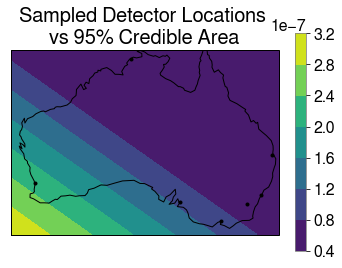

In [30]:
#Plot contour plots over Australia
cred_area_cont_fig = plt.figure(6)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plot_cities()
plt.contourf(mesh_long,mesh_lat,convert_to_coord_matrix(cred_area))
plt.colorbar()
plt.title("Sampled Detector Locations \nvs 95% Credible Area")
plt.show()